# Waste-Sorter

In this notebook, I'm going to replicate and study the work by Collin Ching ([blog](https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478), [repo](https://github.com/collindching/Waste-Sorter)). Collin built an image classifier for waste sorting, based on [this](https://github.com/garythung/trashnet/) work by Gary Thung and Mindy Yang.

## Imports

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

The first step is to import the images [datataset](https://github.com/garythung/trashnet/#dataset). The dataset contains 2527 images organized by material in different folders:

- 501 glass
- 594 paper
- 403 cardboard
- 482 plastic
- 410 metal
- 137 trash

## Import and organize the data

In [0]:
import requests, zipfile, io

req = requests.get( 'https://github.com/bartomolina/dscapstone/blob/master/data/dataset-resized.zip?raw=true' ) 
zf = zipfile.ZipFile(io.BytesIO(req.content))
zf.extractall()

We verify that our data contains all the folders for the different materials:

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['glass', 'trash', 'plastic', 'paper', 'cardboard', '.DS_Store', 'metal']

Collin created different helper functions to help splitting the data into train, test, validation with a 50-25-25 split:

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

And creates a folder structure to store the different images. The folder structure will look like:

```
├── data
│   ├── test
│   │   ├── cardboard1.jpg
│   │   ├── glass1.jpg
│   │   ├── ...
│   ├── train
│   │   ├── cardboard
│   │   │   ├── cardboard2.jpg
│   │   │   ├── ...
│   │   ├── glass
│   │   │   ├── glass2.jpg
│   │   │   ├── ...
│   ├── valid
│   │   ├── cardboard
│   │   │   ├── cardboard3.jpg
│   │   │   ├── ...
│   │   ├── glass
│   │   │   ├── glass3.jpg
│   │   │   ├── ...
```


In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [6]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

Then, he loads the data, with the from_folder function from the [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch) class, which allows extracting the data from a folder with an ImageNet structure, as the one we've created before:

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

Let's have a look at our data:

In [8]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [9]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


We can see that the images have been correctly imported into the different classes. Let's have a quick look at some of the images:

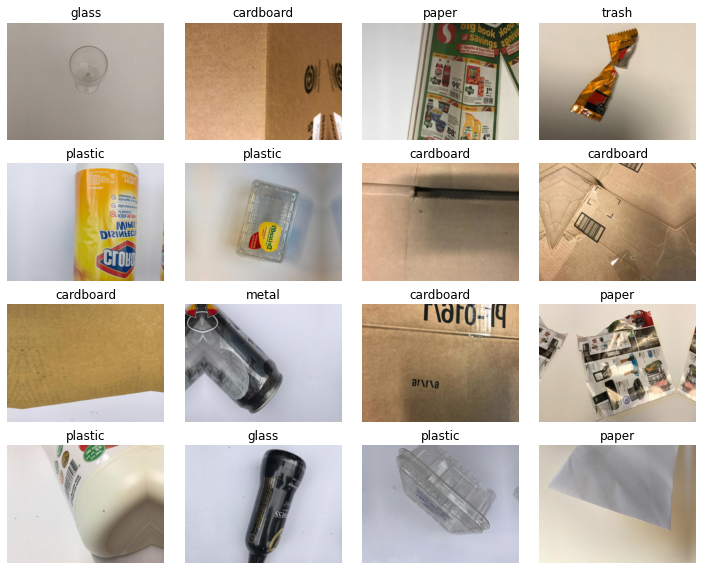

In [10]:
data.show_batch(rows=4,figsize=(10,8))

## Model

### Creating the model (CNN)

In This case, Collin creates a CNN with a single line using fastai create_cnn function, we'll pass our images and the model we're going to use (resnet34). Resnet34 is 34 layer CNN that has been pretrained with images from the [ImageNet database](http://www.image-net.org/). Resnets have been proven to be a great way [to categorize images](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035):


In [11]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Finding an optimal learning rate and train our model

In order to train a Neural Network, one of the key hyperparameters to find is the **learning rate**. The learning rate determines the scale of the weight as you try to minimize the loss function:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-03
Min loss divided by 10: 4.17E-03


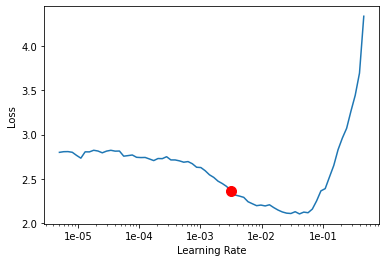

In [13]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

The suggested learning rate, that we'll use is: 3.16E-03. With this, we'll proceed to train our model:

In [15]:
learn.fit_one_cycle(20,max_lr=3.16e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.724964,0.760650,0.279365,00:36
1,1.176948,0.515238,0.161905,00:35
2,0.939839,0.521081,0.161905,00:34
3,0.767799,0.553264,0.184127,00:33
4,0.685701,0.537972,0.158730,00:33
5,0.657927,0.434357,0.152381,00:33
6,0.640137,0.628116,0.187302,00:32
7,0.541587,0.427435,0.166667,00:33
8,0.539898,0.492793,0.146032,00:33
9,0.515111,0.400871,0.120635,00:33


After 20 epochs, the error rate looks pretty good (**6.7%**).

Now that we've trained our model, we're going to have a look at some of the images that were incorrectly classified:

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

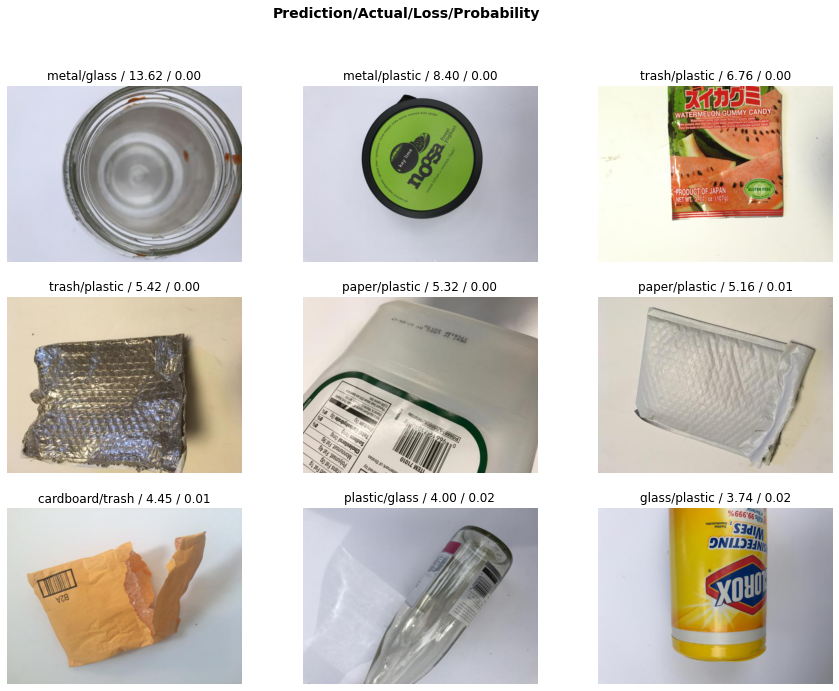

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

We can see that it's normal for some of the images to be incorrectly classified. like the paper/plastic or the cardboard/trash. Other images have been incorrectly classified simply because the quality of the image is pretty poor.

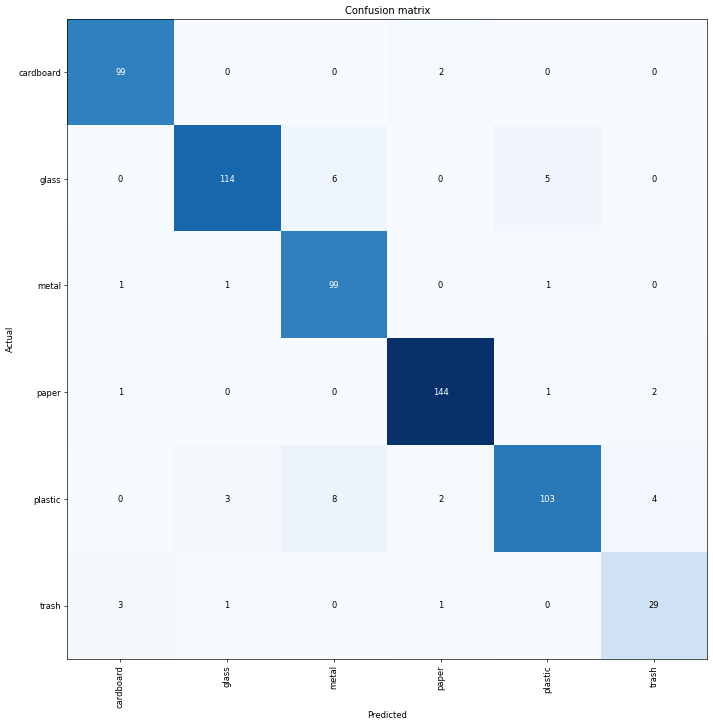

In [18]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('plastic', 'metal', 8),
 ('glass', 'metal', 6),
 ('glass', 'plastic', 5),
 ('plastic', 'trash', 4),
 ('plastic', 'glass', 3),
 ('trash', 'cardboard', 3),
 ('cardboard', 'paper', 2),
 ('paper', 'trash', 2),
 ('plastic', 'paper', 2)]

We've obtained similar resulst as Collin, the model mostly confuses plastic with metal and glass with metal and plastic.

### Predict and model performance

Now that we've trained our model, let's see how well it performs against the test data

In [20]:
preds = learn.get_preds(ds_type=DatasetType.Test)

These are the class predictions for the test data:

In [21]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.8845e-01, 2.9652e-03, 2.0533e-03, 4.4455e-05, 6.2429e-03, 2.4828e-04],
        [1.1098e-06, 1.4255e-07, 1.5281e-08, 9.9989e-01, 5.4852e-05, 5.8729e-05],
        [4.6104e-03, 7.1003e-05, 1.8346e-03, 9.8799e-01, 1.3052e-03, 4.1917e-03],
        ...,
        [9.5704e-05, 1.5984e-05, 4.7532e-02, 5.3782e-04, 9.5180e-01, 1.4544e-05],
        [2.6718e-06, 9.9597e-01, 2.3657e-03, 2.3148e-06, 1.6379e-03, 2.1699e-05],
        [1.1009e-01, 7.6120e-01, 1.1908e-03, 8.8675e-03, 5.3209e-03, 1.1333e-01]])

Let's convert each of the predictions to the actual class:

In [25]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [0]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

These are the first 15 predictions:

In [31]:
yhat[:15]

['cardboard',
 'paper',
 'paper',
 'plastic',
 'trash',
 'plastic',
 'cardboard',
 'plastic',
 'glass',
 'paper',
 'paper',
 'plastic',
 'cardboard',
 'cardboard',
 'metal']

i.e. the third image is correctly classified as plastic:

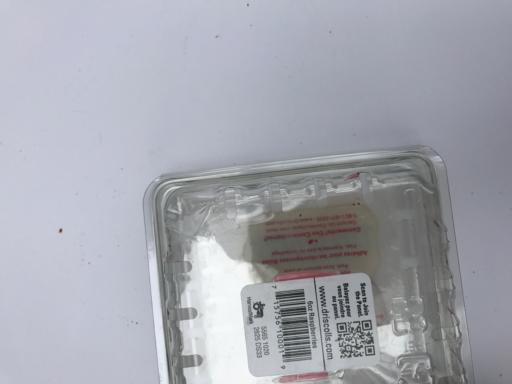

In [35]:
learn.data.test_ds[3][0]

Now, let's get the actual labels and see how our model performed:

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [38]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'paper', 'paper', 'plastic', 'trash']
['cardboard', 'paper', 'paper', 'plastic', 'trash']


We can see that the first images were correctly classified! Now, we're goin to 

In [40]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   3   1   0   0]
 [  0 112  11   0   3   0]
 [  0   7  96   0   0   0]
 [  0   0   1 145   1   2]
 [  0   5   0   1 113   2]
 [  2   1   2   4   1  25]]


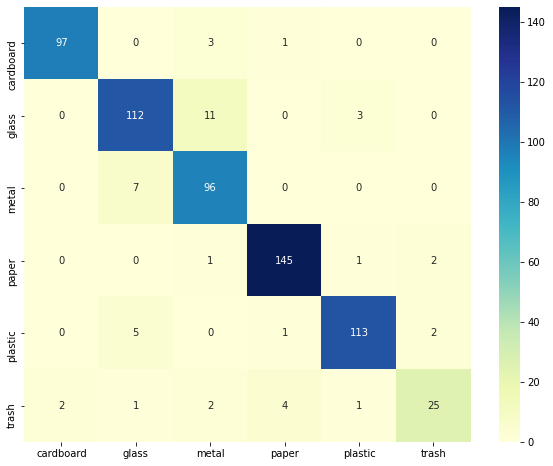

In [41]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In this case, we can see that the model mainly confused glass with metal and plastic as before.

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [43]:
accuracy = correct/sum(sum(cm))
accuracy

0.925984251968504

As expected, the model accuracy (**92.6%**) is in line with the Collin's model (**92.1%**).

### Conclusions 

As Collin mentions, fastai allows you to quicly create a model, and with the help of a pretrained CNN such as resnet34 you can achieve pretty good results for image classification.